# Personal Financial Planning

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML

persfin = os.path.join("./","persfin")
sys.path = [persfin]+sys.path

import fingenerators as fingen
import utilityfuns as ufun
import rentalfuns as rfun


# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

## References

<https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.financial.html>  
<http://pbpython.com/amortization-model-revised.html>  
<http://www.financialmodellinghandbook.com/2014/03/15/sign-conventions/>  
<https://cleffinance.blogspot.com/2012/01/pv-pmt-when-to-put-negative.html>  


<https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/>  
<http://inmachineswetrust.com/posts/understanding-generators/#cell3>  
<https://github.com/NelisW/PythonNotesToSelf/blob/master/Generators.ipynb>


Discounted Cash Flow (DCF):  
https://www.investopedia.com/terms/d/dcf.asp  
https://www.wallstreetprep.com/knowledge/dcf-model-training-6-steps-building-dcf-model-excel/  
http://kaushik316-blog.logdown.com/posts/1651749-stock-valuation-with-python  
https://stackoverflow.com/questions/35849994/financial-modelling-with-pandas-dataframe  

Retirement advice
https://www.investopedia.com/terms/f/four-percent-rule.asp  



## Introduction

This notebook is a collection of calculations attempting to understand the positive (growth) and negative elements (cost and risk) in investments. It is not even considering dealing on the equity markets or other sophisticated financial instruments, but rather investigating small, longer-term, personal-scale  investments.

**A note on dates:**  The default start date in this notebook is 2000-01-01, mainly because it is easy to calculate the term remaining from a round number.  The date 0000-01-01 is not allowed in the Python code, so I start with the year 2000.

In South Africa we use ZAR (R) as monetary unit but I do not use the notation, simply because the same calculations apply irrespective of the monetary unit. South African inflation historically varied between 4% and 6% pa, managed by the central bank to target of 6% max.  Our mortgage bond loan interest rate vary from 8.5% to 10% depending on the age of the bond and the client's risk profile.  Numbers in your country will be different, adapt these calculations as necessary for your environment.

Terminology: 

A *mortgage* is a loan (usually secured by a bond) where the purpose of the loan is to purchase a fixed asset in the name of the borrower, but where the lender has the right to seize the asset if the borrower defaults on payment. The lender's right to seize falls away once the loan is fully repaid.

A *bond* is is a long term load agreement (by contract or certificate) whereby one party undertakes to repay the principal amount of the loan with interest by an agreed date. The term 'bond' is used in this document to imply a bond with a schedule of regular payments, usually monthly. In this notebook the terms bond and mortgage are use mostly equivalently.


## Simple Financial Calculations

The sign of a financial value is often confusing: some are positive others are negative. 

* When money is taken out from your pocket (outflows, you pay): use a negative sign.  
* When money is given to you (inflows, pay to you), use a positive sign.

When you borrow money, the capital principal is flowing in, it must be positice. The interest and payment due is flowing out, it must be negative.

When you withdraw from an investment, the capital flowed out when making the investment, hence it must be negative.
The withdrawal is flowing in, it must be positive.

Python's `numpy` package provides basic financial functions:
1. How large a monthly payment is required to repay bond?
1. How much interest or capital is paid in a specific period (a month in this case)?


In [2]:
# to calculate example bond repayment values
Interest_Rate = 0.09
BondYears = 20
cyclesPerAnnum = 12
Principal = 1000000
start_date = (date(2000,1,1))

pmt = np.pmt(Interest_Rate/cyclesPerAnnum, BondYears*cyclesPerAnnum, Principal)
print(f'Payment required {pmt:.2f} to pay back loan plus interest in {BondYears} years')

# Period/month for which to calculate
for per in [0,BondYears*cyclesPerAnnum]:
    # Calculate the interest for this period
    ipmt = np.ipmt(Interest_Rate/cyclesPerAnnum, per, BondYears*cyclesPerAnnum, Principal)
    # Calculate the principal
    ppmt = np.ppmt(Interest_Rate/cyclesPerAnnum, per, BondYears*cyclesPerAnnum, Principal)
    print(f'In month {per:3d} interest payment {ipmt:6.2f}, capital repayment {ppmt:6.2f}')

BondYears = 5
pmt = np.pmt(Interest_Rate/cyclesPerAnnum, BondYears*cyclesPerAnnum, Principal)
print(f'Payment required {pmt:.2f} to pay back loan plus interest in {BondYears} years')

Payment required -8997.26 to pay back loan plus interest in 20 years
In month   0 interest payment -7511.15, capital repayment -1486.11
In month 240 interest payment -66.98, capital repayment -8930.28
Payment required -20758.36 to pay back loan plus interest in 5 years


Someone once said that if you invest 33000 on the day of the child's birth, that should provide sufficient to retire at the age of 65. Let's test this.
Growth of a fixed amount to grow for some years, compounded monthly at interest rates of 1 to 10% above inflation.
The effect of inflation is removed by considering the investment interest rate minus the inflation rate.
Also, following the 4% rule, we divide the end value byi 25 to get the annual pension.
Looking at these numbers, it seems you have to sustain (inflation + 9% to 10%) over the full 65 years to reach at least a miminal or reasonable pension. Let us also ask how much money should you invest at 4% above inflation at birth to reach monthly pension of 50000 at age 65? You need to invest more than a million (assuming no additional payments).

In [3]:
# to see how much money will accrue over 65 years from birth
years = 65
monthsperyear = 12
presentValues = [-33000, -1100000]

dfSum = pd.DataFrame()

for presentValue in presentValues:
    df = pd.DataFrame()
    df['Interest above inflation %'] =  pd.Series(np.linspace(1,10,10)).transpose()
    df['Future value'] =  np.fv(df['Interest above inflation %']/(monthsperyear*100),
                            nper=years*monthsperyear, pmt=0, pv=-presentValue)
    df['Monthly pension'] = df['Future value'] / (25 * 12)
    df['Initial'] = presentValue
    
    dfSum = dfSum.append(df)

dfxp = pd.pivot_table(dfSum, index=['Interest above inflation %'],values=['Monthly pension'],
                      columns=['Initial'])
display(HTML(dfxp.to_html()))


## Compound interest conversions

http://umanitoba.ca/faculties/management/acctfin/stangeland/9.220/old/ratecon2.doc

The future value $F$ of a compounded interest present value $P$  is
$$
F = P \left(
1+\frac{i^{<m>}}{m}
\right)^m
$$
where $m$ is the number of accumulations and $i^{<m>}$ is the annual-expressed interest, with the understanding that it will be compounded $m$ times per year.

To convert between different compounding intervals note that the present value and future values must be the same, hence

$$
\left(
1+\frac{i^{<n>}}{n}
\right)^n =  \left(
1+\frac{i^{<m>}}{m}
\right)^m
$$

$$
i^{<n>}
 =  
n\left[\left(
1+\frac{i^{<m>}}{m}
\right)^{\frac{m}{n}}-1\right]
$$

This function is implemented as `utilityfuns.convertcompounded(n,m,imc,returnstr=False)` in the `persfin` module.

The effective annual rate for a stated rate of 7.5% per year compounded quarterly:
$n=1$ and $m=4$, hence


In [4]:
# to calculate effective rate for annual rate compounded quarterly
print(ufun.convertcompounded(1,4,0.075,True))

Effective x1 rate of 0.075 compounded x4 is 0.07713586578369158


Fund managers take a commission as percentage of the *investment balance*.  One company, Coronation quote rates of up to 2% or even 3% on the investment value, compounded daily. What is the effect of daily compounding?  The difference may seem small but on large amounts of money, this difference can result a significant sum of money.

In [5]:
# to calculate the effective rate for annual rate compounded daily
print(ufun.convertcompounded(1,365.25,0.02, True))
print(ufun.convertcompounded(1,365.25,0.03, True))

Effective x1 rate of 0.02 compounded x365.25 is 0.02020078141545234
Effective x1 rate of 0.03 compounded x365.25 is 0.030453264469993968


In [6]:
# to investigate compounding in various directions
print(ufun.convertcompounded(1,365.25,0.095,True))
print(ufun.convertcompounded(1,12,0.095, True))
print('')
print(ufun.convertcompounded(1,365.25,0.06, True))
print(ufun.convertcompounded(1,12,0.06, True))
print(ufun.convertcompounded(365.25,1,0.06, True))
print(ufun.convertcompounded(12,1,0.06, True))


Effective x1 rate of 0.095 compounded x365.25 is 0.09964527177314153
Effective x1 rate of 0.095 compounded x12 is 0.09924758408100764

Effective x1 rate of 0.06 compounded x365.25 is 0.06183131426116972
Effective x1 rate of 0.06 compounded x12 is 0.06167781186449828
Effective x365.25 rate of 0.06 compounded x1 is 0.05827355623654029
Effective x12 rate of 0.06 compounded x1 is 0.05841060678411658


## Time Value of Money

Inflation erodes the buying power of money over time.  As long as your salary keeps track, or exceeds, of inflation, the erosion effect might not be very noticeable. However, if your salary increases slower than inflation, your buying power decreases with time.

From the table below (assuming compounded annually) it is evident that the value of money halves in 11.5 years if the inflation rate is 6%.

,Inflation %,Years-to-half
0,3.0,23.13378
1,4.0,17.35754
2,5.0,13.89180
3,6.0,11.58131
4,7.0,9.93096
5,8.0,8.69319
6,9.0,7.73048
7,10.0,6.96031
8,11.0,6.33018
9,12.0,5.80506


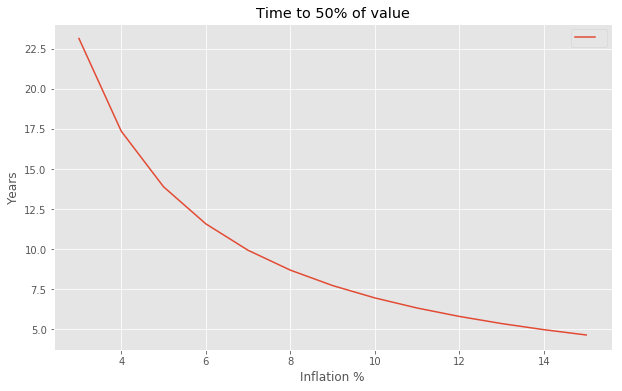

In [7]:
# to calculate the time value of money for different inflation rates
df = pd.DataFrame()
df['Inflation %'] =  np.linspace(3,15,13)
df['Years-to-half'] = -np.log(0.5)/np.log(1+df['Inflation %']/(100*12))/12
display(HTML(df.to_html(index=True)))

figsize(10,6)
fig, ax = plt.subplots(1, 1)
df.plot(x='Inflation %', y='Years-to-half', label=f'', ax=ax)
plt.title("Time to 50% of value");
plt.ylabel("Years");

## Mortgage Bond Amortisation 

See the `01-Mortgage-Amortisation` notebook.


## Investment Growth

In [ ]:
def investmentgrowth(initialvalue, growthrate, termyears, addpayment=0, addpaymentrate=0, 
                     costBalPcnt=0, start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID=''):
    """
    Calculate the amortization schedule given the loan details.

    :param initialvalue: Initial value paid into the investment
    :param growthrate: The annual growth rate for this investment
    :param termyears: Number of years for the investment
    :param addpayment: Additional investment amount per period
    :param addpaymentrate: growth in the additional investment compounded annually 
    :param costBalPcnt: managment cost as percentage on balance
    :param start_date: Start date for the loan.
    :param cyclesPerAnnum: Number of investment payment cycles in a year.
    :param ID: String ID for this calculation.

    :return: 
        schedule: investment schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = initialvalue
    end_balance = initialvalue
    currentyear = start_date.year

    while p < termyears * cyclesPerAnnum:
        
        # Recalculate the growth based on the current balance
        growth = - beg_balance * growthrate / cyclesPerAnnum
        
        # cost on balance
        costBal = beg_balance * costBalPcnt / cyclesPerAnnum
        
        # total costs
        costs = costBal
        
        end_balance = beg_balance - growth + addpayment - costs

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('InitialVal', initialvalue),
                           ('GrowthRate', growthrate),
                           ('Growth', growth),
                           ('AddPayment', addpayment),
                           ('AddPayRate', addpaymentrate),
                           ('CostBalance',costBal),
                           ('End Balance', end_balance),
                           ('ID', ID),
                          ])
        
        # Increment the counter, balance and date
        p += 1
        if cyclesPerAnnum == 12:
            start_date += relativedelta(months=1)
        elif  cyclesPerAnnum == 365.25:
            start_date += relativedelta(days=1)
        else:
            print(f'Unknown cyclesPerAnnum = {cyclesPerAnnum}')
            return None
        beg_balance = end_balance
        
        # only increase the additional payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            addpayment *= 1 + addpaymentrate

In [ ]:
def investment_table(initialvalue, growthrate, termyears, addpayment=0, addpaymentrate=0, costBalPcnt=0,
                     start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID=''):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param initialvalue: Initial value paid into the investment
    :param growthrate: The annual growth rate for this investment
    :param termyears: Number of years for the investment
    :param addpayment: Additional investment amount per period
    :param addpaymentrate: growth in the additional investment compounded annually 
    :param costBalPcnt: managment cost as percentage on balance
    :param start_date: Start date for the loan.
    :param cyclesPerAnnum: Number of investment payments in a year.
    :param ID: String ID for this calculation.

    :return: 
        schedule: investment schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the investment
    """
    
    # Generate the schedule 
    schedule = pd.DataFrame(investmentgrowth(initialvalue=initialvalue, growthrate=growthrate, 
                                termyears=termyears,addpayment=addpayment, addpaymentrate=addpaymentrate, 
                                             costBalPcnt=costBalPcnt,start_date=start_date, 
                                             cyclesPerAnnum=cyclesPerAnnum,ID=ID))
    
    # reorder the columns
    schedule = schedule[['Period','Month','Begin Balance','InitialVal','GrowthRate','Growth',
                         'AddPayment','AddPayRate','End Balance','ID']]

    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    endBalance = schedule.iloc[-1]["End Balance"]
    stats = pd.Series([ID,initialvalue,growthrate,
                       termyears,addpayment,addpaymentrate,
                       endBalance,costBalPcnt],
                       index=['ID','InitialVal','GrowthRate',
                              'Years','AddPayment','AddPayRate',
                              'EndBalance','CostBalPcnt'])
    
    return schedule, stats

### The True Cost of Commission on Value of Investments

From 
https://www.coronation.com/personal/new-investor/about-unit-trusts/:  
"A unit trust (also known as a ‘fund’) pools money from many investors to invest in assets like shares, bonds and property. Instead of having to pick individual investments yourself, a unit trust offers you exposure to a range of assets, which are selected and managed by investment professionals. Each fund is divided into equal units. The price of each of these units is based on the value of all the investments in the fund. As an investor, you own a number of units in a fund. Over time, the price of these units will track the value of the underlying investments. 
Coronation does not charge any initial or upfront fees to invest in our unit trust funds. Your full investment amount is invested to purchase units. Our unit trusts charge an annual management fee which is calculated daily. Certain funds may charge a performance fee which is accrued daily and paid monthly for all funds, except the Coronation Optimum Growth fund which is paid annually on 30 September. For more information, please view our Fee Schedule in the forms section on Coronation.co.za. "
The Coronation schedule lists fees of 0.85% to 1.25%, and in some funds even 3% (Domestic long term Top 20). Other fund managers have similar fees.

When comparing these fees to the investment value, the term Total Expense Ratio (TER) is often used.
From <https://www.investopedia.com/terms/t/ter.asp>  
"The total expense ratio (TER) is a measure of the total costs associated with managing and operating an investment fund, such as a mutual fund. These costs consist primarily of management fees and additional expenses, such as trading fees, legal fees, auditor fees and other operational expenses. The total cost of the fund is divided by the fund's total assets to arrive at a percentage amount, which represents the TER. TER is also known as the 'net expense ratio' or 'after reimbursement expense ratio'."


The fund manager takes this fee on a daily basis (compounded) irrespective of the performance of the investment. The investment grows slower because of the investment commission. If the investment is not growing positively, the investment loses money at these daily compounded rates. 

Consider the effect of a percentage cost on the value of an investment to the long term value.
The scenarios considered here are for an initial investment followed by either no further investment or a fixed monthly investment.
Different values for management commission are considered where zero commission is the baseline for best possible growth.

In [ ]:
initialvalue = 1000
growthrate = 0.06
termyears = 30
addpayments = [0,100]
addpaymentrate = 0.
costBalPcnts = [0.0, 0.01, 0.015, 0.02, 0.03]
cyclesPerAnnum = 12

dfSum = pd.DataFrame()

for addpayment in addpayments:
    for costBalPcnt in costBalPcnts:
        schedule, stats = investment_table(initialvalue, growthrate, termyears, addpayment=addpayment, 
                                   addpaymentrate=addpaymentrate,costBalPcnt=costBalPcnt,ID='',
                                  cyclesPerAnnum=cyclesPerAnnum)
        
        # append all summaries into single df
        dfSum = dfSum.append(stats,ignore_index=True)


In [ ]:
pd.pivot_table(dfSum, index=['CostBalPcnt'],values=['EndBalance'],columns=['AddPayment'])

Normalise the fund value by the scenario where there is zero costs. When the investment is measured against this baseline, the true cost of the commission becomes apparent.

In [ ]:
# calculate a normalised end balance for the different scenarios
dfSum['EndBalanceN'] = np.nan
AddPaymentU = dfSum['AddPayment'].unique()
for addpayment in addpayments:
    normval = dfSum.loc[(dfSum['CostBalPcnt'] == 0) & (dfSum['AddPayment'] == addpayment)]['EndBalance'].values[0]
    dfSum.loc[dfSum['AddPayment'] == addpayment,'EndBalanceN'] = (dfSum.loc[dfSum['AddPayment'] == addpayment,'EndBalance'])/normval


In [ ]:
pd.pivot_table(dfSum, index=['CostBalPcnt'],values=['EndBalanceN'],columns=['AddPayment'])

The table says the following:
    
1. If a lump sum only is invested with no future payments:
    1. a commission of 1% consumes 25% of the total investment value.
    1. a commission of 2% consumes 45% of the total investment value.
    1. a commission of 3% consumes 60% of the total investment value.


1. If a lump sum only is invested followed up with monthly future payments:
    1. a commission of 1% consumes 18% of the total investment value.
    1. a commission of 2% consumes 32% of the total investment value.
    1. a commission of 3% consumes 43% of the total investment value.


----------------------------------------------

## Retirement Fund Depletion

A key question when it comes to retirement, is 'how long will the money last?'
The answer to this question depends on very many factors including predictable and unpredictable factors
Unpredictable factors include new investment opportunities and risks such as ill health, market crashes and crime. The answer also depends somewhat on (uncontrollable) factors that can be estimated or at least modelled by making reasonable assumptions.  These factors include investment growth and inflation, which we can use in models to predict outcomes, given the occurrence of these factors.  These assumptions can be long term averages (assuming stationary conditions) or can be variable on the time line, our modelling must just be able to handle these assumptions.

### Four Percent Rule

Fund managers currently advise that you do not with draw more than 4% to 5% per year of your total investment portfolio, in order to outlive your retirement funds. This is known as the [four percent rule](https://www.investopedia.com/terms/f/four-percent-rule.asp). This means that if you saved 1000k, the annual withdrawal should not be more than 40k to 50k. Put differently, you need a portfolio of 25 to 20 times your required annual pension. If you want to retire with 1m per year, you need a portfolio of 25m.
The purpose with this analysis is to confirm this advice and to determine the assumptions made in this general advice.

The [four percent rule](https://www.investopedia.com/terms/f/four-percent-rule.asp) aims to ensure that you do not run out of money during requirement.  The idea is that investment growth will normally be sufficient to cover a four percent withdrawal from the investments per annum.  This rule is based on 50-year data prior to the mid 1970's in the US

This rule is not always valid for all people.  As people grow older or require more medical care the the four percent withdrawal may not sustain until death. If the person has high risk investments too high a withdrawal rate (even four percent) may pose a risk in later years.  Occasional high spending may also erode the investment to prevent long term returns.

The analysis below provides some insight into the role of percentage withdrawals on the sustainability of long term retirement.

### Time value of money

Inflation and investment have the effect of predicting very large numbers in the longer term.  These large numbers are difficult to interpret from the present; we loose the 'feel' of what money really is worth.

Suppose it is possible to freeze the time value of money, to always retain a constant buying power.  With the time value of money frozen, we can evaluate the value of asset growth and costs in a manner decoupled from the erosion effect of inflation: we evaluate the investment or cost in terms of  true buying power.  The money value would always have constant buying power irrespective of time into the future.

The underlying principle used here is similar to the financial tool called Discounted Cash Flow (DCF) except that the target calculation here is to determine the time when the investment will be depleted given constant monthly withdrawal that probably exceeds the monthly growth, eating away into the investment capital.

Freezing the time value of money is readily done by considering any costs or growth relative to the inflation rate. Simply subtract the inflation rate from investment growth and from cost growth.  
If the inflation rate is 6% and an investment realises 8% growth after tax and costs, the real growth (corrected for inflation) is 2%. If medical inflation rises by 9% in a 6% inflation economy, it means that in real terms the medical costs increases by 3% per year.  Hence the effect of inflation on time value of money can be removed by considering all costs and growth relative to inflation: just subtract inflation rate.

### Retirement fund depletion: simple model, assuming stationary markets

In the (simple) initial study shown below, long term average values are used (constant over the full term duration).  This is quite limiting in that long average are not good predictors, but at least it gives us an idea of what could happen under stationary conditions.  However, there is sufficient evidence that investment returns are not stationary, not even in the longer term. For this purpose a more representative model using actual market movements and Monte Carlo simulations will be developed later.

Of course, this a a very simple model, assuming stationary conditions (other than inflation).
A more advanced model can have time varying inflation, cost, and investment growth, but the underlying principle would still remain: subtract the inflation rate from the cost and investment growth rates.

#### Simple model calculation approach

Many years ago I modelled a very simple retirement fund depletion model in an Excel [spreadsheet](https://github.com/NelisW/RetirementPlanning/blob/master/Retirement%20Planning.xls) and now will expand on that model in Python/Pandas. The model is as follows:

1. Start with an initial investment value, a single number of the investment portfolio total value.

1. Iterate on a monthly interval and repeat the following calculation:

    1. Withdraw money from the portfolio (pension to live from, medical costs, etc.). 

    1. Allow the withdrawal amount to rise in the next month by a percentage equal to the actual rise percentage minus the inflation percentage. In other words, allow the withdrawal to rise in real terms, corrected for inflation.  We allow this growth to assure that medical inflation will be covered (medical inflation is generally higher than cost of living inflation).

    1. Add a portfolio investment growth amount as expected % growth minus % inflation for the month. In other words add the real growth, corrected for inflation.

1. Repeat month by month, until the money runs out.

This model is really simple with several failings:

1. Inflation and investment growth are not stationary and often vary in contrary motion.

2. Different investment classes perform differently, with different risks and different cycles. To simplify growth in into a single number is a gross simplification of the real situation.





The calculation procedure are similar to the amoritisation, using a generator function to iterate until the investment is depleted or `maxyears` are reached.

In [ ]:
def investmovement(initialsum, growthrate, withdrawal, withdrawalrate, 
                    start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID='',maxyears=55):
    """
    Calculate the retirement investment schedule given the growth and withdrawal rates.

    All rates are real rates, corrected for inflation

    :param  initialsum:  total portfolio must be positive
    :param  growthrate:  rate at which investment grows
    :param  withdrawal:  monthly withdrawal at start of retirement
    :param  withdrawalrate:  annual rate of increase in withdrawal
    :param  start_date:  retirement date
    :param  cyclesPerAnnum: normally 12 months per year
    :param  ID: identification for this calculation
    :param  maxyears: terminate the run after so many years

    :return: 
        schedule: retirement investment schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = initialsum
    end_balance = initialsum
    currentyear = start_date.year

    while end_balance < 0 and p <maxyears * cyclesPerAnnum + 2:
        
        # withdraw money at the beginning of month
        if beg_balance > withdrawal:
            withdrawal = beg_balance
            
        beg_balance = beg_balance - withdrawal 

        # Recalculate the growth based on the current balance
        growth =  (growthrate/cyclesPerAnnum) * beg_balance
        end_balance = beg_balance + growth
        
        if np.abs(end_balance) < 1:
            end_balance = 0

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('BeginBalance', beg_balance),
                           ('EndBalance', end_balance),
                           ('Initialsum', initialsum),
                           ('Growth', growth),
                           ('GrowthRate', growthrate),
                           ('WithdrawalRate', withdrawalrate),
                           ('Withdrawal', withdrawal),
                           ('ID', ID),
                          ])
        

        # Increment the counter, balance and date
        p += 1
        
        if cyclesPerAnnum == 12:
            start_date += relativedelta(months=1)
        elif  cyclesPerAnnum == 365.25:
            start_date += relativedelta(days=1)
        else:
            print(f'Unknown cyclesPerAnnum = {cyclesPerAnnum}')
            return None

        beg_balance = end_balance
        
        # only increase the withdrawal payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            withdrawal *= 1 + withdrawalrate


def investmovement_table(scenario,initialsum, growthrate, withdrawal, withdrawalrate, retire_age=65,
                    start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID='',maxyears=55):
    """
    Calculate the retirement investment schedule given the investment and withdrawal details

    :param  scenario:  string identifier
    :param  initialsum:  total portfolio must be positive
    :param  growthrate:  rate at which investment grows
    :param  withdrawal:  monthly withdrawal at start of retirement
    :param  withdrawalrate:  annual rate of increase in withdrawal
    :param  retire_age:  age at the start of fund depletion
    :param  start_date:  retirement date
    :param  cyclesPerAnnum: normally 12 months per year
    :param  ID: identification for this calculation
    :param  maxyears: terminate the run after so many years

    :return: 
        schedule: investment schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Generate the schedule 
    schedule = pd.DataFrame(investmovement(initialsum, growthrate, withdrawal, withdrawalrate,
                                           start_date=start_date,ID=ID,maxyears=maxyears))
    if schedule.empty:
        stats = pd.Series([scenario,0,0,initialsum,0,growthrate,withdrawalrate,withdrawal,ID],
                   index=['Scenario','Duration','Age@End','Initialsum','EndBalance','GrowthRate','WithdrawalRate','Withdrawal','ID'])
        return None, stats

    # reorder the columns
    # schedule = schedule[['Month','Period','BeginBalance','Initialsum','GrowthRate','WithdrawalRate','Withdrawal','ID']]
    
    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    endbalance = schedule["EndBalance"].iloc[-1]
    final_date = schedule["Month"].iloc[-1]
    final_withdraw = min(schedule["Withdrawal"].iloc[-1],schedule["Withdrawal"].iloc[-2])
    duration = ((final_date - pd.to_datetime(start_date))/(12 * np.timedelta64(1, 'M')))
    age_end = retire_age + duration
    #Create a summary statistics table
    stats = pd.Series([scenario,duration,age_end,initialsum,endbalance,growthrate,withdrawalrate,withdrawal,final_withdraw,ID],
                       index=['Scenario','Duration','Age@End','Initialsum','EndBalance','GrowthRate','WithdrawalRate','Withdrawal','WithdrawalFinal','ID'])
    
    return schedule, stats

if False:
    initialsum = -1000000
    growthrate = +.01
    withdrawalrate = +.01
    withdrawal = -3333
    retire_age=65
    scenario = 'Test'
    maxyears = 30
    df, stats = investmovement_table(scenario=scenario,initialsum=initialsum, growthrate=growthrate,
                 withdrawal=withdrawal, withdrawalrate=withdrawalrate,retire_age=retire_age,ID='',maxyears=maxyears)

    print(df.head(20))
    print(df.tail(20))
    print(stats)

Evaluate a number of scenarios with different investment growth rate and withdrawal growth rate.  Remember that these rates are relative to inflation. The withdrawal growth rate could well be above cost of living inflation, because of medical inflation that increases at old age.  Some advisors estimate medical inflation to be as high as 3% to 5% above inflation.  The present calculation does not provide for medical expense as a separate cost item, it must be factored into the withdrawal growth.

The set of scenarios evaluated next are the same as in my previous spreadsheet, serving as a reference against the previous baseline.

In [ ]:
def stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=55):

    dfa = pd.DataFrame()
    dfSum = pd.DataFrame()

    for annualwithdrawal in  annualwithdrawals:
        withdrawal = initialsum * annualwithdrawal / 12

        for scenario in scenarios:
            growthrate = scenarios[scenario]['growthrate']
            withdrawalrate = scenarios[scenario]['withdrawalrate']

            df, stats = investmovement_table(scenario=scenario,initialsum=initialsum, growthrate=growthrate,
                     withdrawal=withdrawal, withdrawalrate=withdrawalrate,retire_age=retire_age,ID='',maxyears=maxyears)

            dfa = dfa.append(df)

           # append all summaries into single df
            dfSum = dfSum.append(stats,ignore_index=True)

    dfSum['Ratio'] = dfSum['Initialsum']/(12 * dfSum['Withdrawal'])
    dfSum['Withdrawal0'] = 1 / dfSum['Ratio']
    
    newbalancename = f'End balance as percentage of initial after {maxyears} years'
    dfSum[newbalancename] = dfSum['EndBalance']
    
    newagename = f'Age at funds depleted or {maxyears} years, retirement at {retire_age}'
    dfSum[newagename] = dfSum['Age@End']
    
    newdurationname = f'Duration till funds depletion or {maxyears} years'
    dfSum[newdurationname] = dfSum['Duration']
    
    withdrawalfinalname = f'Withdrawal in final year of funds depletion or {maxyears} years as a percentage of initial investment'
    dfSum[withdrawalfinalname] = dfSum['WithdrawalFinal'] * 12 / initialsum
    
    dfAgeEnd = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newagename],columns=['Scenario'])
    dfDuration = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newdurationname],columns=['Scenario'])
    dfMoneyLeft = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newbalancename],columns=['Scenario']) * 100 /  initialsum  
    dfFinWithDr = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[withdrawalfinalname],columns=['Scenario'])  

    return dfSum,dfAgeEnd,dfDuration,dfMoneyLeft,dfFinWithDr,newbalancename,newagename,newdurationname,withdrawalfinalname

In [ ]:
initialsum = -1000000
retire_age = 65
maxyears = 30

scenarios = {
    'g-0.02, w0.00':{'growthrate':-0.02, 'withdrawalrate':0.00},
    'g-0.02, w0.01':{'growthrate':-0.02, 'withdrawalrate':0.01},
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.00, w0.01':{'growthrate':0.00, 'withdrawalrate':0.01},
    'g0.00, w0.02':{'growthrate':0.00, 'withdrawalrate':0.02},
    'g0.00, w0.04':{'growthrate':0.00, 'withdrawalrate':0.04},
    'g0.02, w0.00':{'growthrate':0.02, 'withdrawalrate':0.00},
    'g0.02, w0.01':{'growthrate':0.02, 'withdrawalrate':0.01},
    'g0.02, w0.02':{'growthrate':0.02, 'withdrawalrate':0.02},
#     'g0.04, w0.0':{'growthrate':0.04, 'withdrawalrate':0.00},
#     'g0.10, w0.0':{'growthrate':0.10, 'withdrawalrate':0.00},
#     'g0.04, w0.04':{'growthrate':0.04, 'withdrawalrate':0.04},
}

annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSum,dfAgeEnd,dfDuration,dfMoneyLeft,dfFinWithDr,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

In the tables shown below each row represents a different initial withdrawal percentage (i.e., the 'four percent rule') expressed as a percentage of total investment and also as the ratio of investment sum to initial withdrawal.

Retiring at age 65, the money will run out at the ages shown in the table below.
If you want to retire at age 65, with life expectancy in the table, you need Ratio times the initial annual pension at 65.
So, retiring at age 65, with a pension of 1m/year, if you have 25m, it will last until age 85-90, depending on growth and withdrawals.
How long the money will last depends on the relative growth of investments vs increasing costs such as medical and other age-related expenses.
Medical costs typically grow 3-4% above inflation. However, assuming that some other costs grow less, we can work with a somewhat smaller average cost growth. So your investments must beat medical by at least, say, 2%.

The following are not included in the calculation:

1. Taxes on investment and personal income tax are not accounted for in these calculations.

1. Costs on investments such as broker fees, agent fees and fund manager fees.

1. Variations in market growth and inflation, for this calculation these are assumed constant.  It is assumed that market growth and withdrawal growth follows/tracks inflation and that they all move up or down together. This is not the case, because when inflation and investment growth tends to move antithetical.

Explanation of the tables below:

1. The rows downward shows the initial annual withdrawal (Withdrawal0) in the first year (start of pension) as percentage of total investment amount. This annual withdrawal amount expressed as an amount will then increase at the percentage rate 'w' shown in the various columns.  In other words the pension withdrawal is allowed to grow at some rate relative to inflation.  The value in the Ratio column is the ratio of total investment to the first year's (start of pension) annual withdrawal.

1. In the table headings below there are two numbers 'g0.00. w0.00' the 'g' number is annual percentage investment growth (after cost) above inflation and the 'w' number is the annual percentage withdrawal growth above inflation (to account for medical inflation). 

1. The *first row* is the 'Four percent rule' which means that in the first year of pension 4% or 1/25 of the total investment is withdrawn.  It is clear that if there is zero growth above inflation, and the withdrawal is kept constant at the same percentage (above inflation), the investment should last until the age of 90 (about 25 years).  On the other hand, with a 4% growth above inflation and constant withdrawal rate, the money should last more than 55 years (the simulation terminates at 55 years).


1. The *first column* `g0.00, w0.00` represents the scenario with zero annual growth (above inflation) and zero annual withdrawal increase (above inflation). The column shows that as the initial withdrawal increases from the minimum 2.5% to the maximum 17.5% allowed in South Africa, the pension duration shrinks from thirty years to just five and half years!


In [ ]:
display(HTML(dfAgeEnd.to_html()))

The graph below shows the same information (the age where the funds are depleted) versus the (ratio of assets at retirement to annual income during retirement).

These graphs apply to a retirement age of 65 years.  It is much worse for forced retirement at an earlier age.
The various lines show growth in medical expenses and in the remaining assets, in real terms (i.e. relative to inflation).
Life expectancy for professional people with a healthy lifestyle currently is 92 years --- almost 30 years after retirement.
For the above life expectancy one requires total assets between 20 and 25 times your annual withdrawal at retirement.

For example, to survive till the age 92, with 1% growth in medical expense, and 2% net growth in invested assets, 
and to support an equivalent annual withdrawal of 100 000 at retirement, you require 25 times or 2,5m in assets.

For a ratio of 22, it is evident that your funds will be depleted 5 years later, if the real growth is 2% instead of 0% (for medical of 1%).

In [ ]:
 
figsize(16,8)
fig, axes = plt.subplots(nrows=1, ncols=2)
for scenario in scenarios:
    dfSum[dfSum['Scenario']==scenario].plot(x='Withdrawal0',y='Age@End', label=scenario, ax=axes[0])    
    dfSum[dfSum['Scenario']==scenario].plot(x='Ratio',y='Age@End', label=scenario, ax=axes[1])    
    
for i in [0,1]:
    axes[i].set_title(f"Retirement investment depletion from age 65 or {maxyears} years");
    axes[i].set_ylabel("Funds depleted at age");
    axes[i].set_ylim([70,maxyears+retire_age])

axes[0].set_xlabel("Percentage withdrawal");
axes[1].set_xlabel("Asset/Annual ratio");
axes[0].set_xlim([0.04,0.18])
axes[1].set_xlim([5,25]);


If the investment growth is the same as the increase in withdrawal rate

In [ ]:
display(HTML(dfDuration.to_html()))

The following table shows the money left in the investment for the different scenarios and the durations shown in the previous table.  In this case the only scenario with reserves is the high growth scenario. In all other cases the funds were depleted at the end of the durations shown above.

In [ ]:
display(HTML(dfMoneyLeft.to_html()))

### Covering increasing medical or other costs

We often think of medical costs only as required to repair illness and disease. This is true in younger years, but in elder years a nominally healthy person also incurs considerable expenses in the form of medication and preventative medical care. As the body breaks down, even in healthy people medical costs rise.
Medical cost is a given: in sick people it is the cost of caring and repairing, in nominally healthy people it is the cost of maintaining and preventing. Either way, the cost is there.  The cumulative cost of a nominally healthy person living into the nineties may even exceed the cumulative cost of a sick person that lives for a shorter period.

Consider the effect of increased withdrawal during the duration of the pension, assuming fund growth equal to inflation (i.e., zero real growth).
The following table shows the final year withdrawal, as multiple of the initial withdrawal during the first year of plan, in real terms.
Corrected for inflation, how much more money are you withdrawing in the final year for a given withdrawal growth scenario?

In this table, the final withdrawal is taken in the final year when the fund is depleted, or at `maxyears` when the simulation stops.

The numbers differ significantly for different initial withdrawal percentages; perhaps not surprisingly, because higher withdrawals result in  shorter durations.  What is important here is that for lower initial withdrawals, there is much more headroom for additional expenses in the longer terms.  At high initial withdrawals, there is very little 'extra' money to fund additional expenses.

So the lesson here is: keep the initial withdrawal as low as possible to extend the duration of the pension and to allow for more headroom for additional expenses towards the end.

In [ ]:
dfx = dfSum[dfSum['Scenario'].isin(['g0.00, w0.00','g0.00, w0.01','g0.00, w0.02','g0.00, w0.04'])][[
    'Withdrawal0','WithdrawalFinal','Scenario','Duration',newagename]]
dfxp = pd.pivot_table(dfx, index=['Scenario'],values=['WithdrawalFinal'],columns=['Withdrawal0'])
dfxp = dfxp / dfxp.iloc[0]
display(HTML(dfxp.to_html()))

dfxp = pd.pivot_table(dfx, index=['Scenario'],values=['Duration'],columns=['Withdrawal0'])
display(HTML(dfxp.to_html()))

dfxp = pd.pivot_table(dfx, index=['Scenario'],values=[newagename],columns=['Withdrawal0'])
display(HTML(dfxp.to_html()))




Assuming that living cost exactly follows inflation, some additional withdrawal increase (over and above inflation) is required to provide more money in real terms to cover increasing medical costs. 
Suppose that medical costs in the final year equal the basic living cost, you need double the pension income. This is not an unrealistic scenario for a nominally healthy person approaching elderly years requiring regular medical attention.  If fact, this scenario may not even cover the cost of 24-hour care or frail care clinic admission.
1.97 x (almost double) the purchasing power in the final year can be obtained from a 4% initial withdrawal, if it grows by 4% (above inflation) annually.
However, this 4% growth is not required in the early years, only towards the later years. The present model assumes and implements a fixed rate throughout the duration. A more sophisticated model will follow later.

The worrying thing about increasing the withdrawal amount, is that the duration falls from 25 years with no increase in withdrawal, to 17 years  with 4% increase per annum (age 82 for retirement of 65).

It seems that to meet rising medical costs, you have to 'overdraw' quite substantially towards later years.
Your view may differ on the details of this this conclusion, but considering people close to me, I believe that the plan must make provision to cover medical costs equal to or even exceeding basic cost of living towards the end of life.


### Effect of market growth

Assuming no increase (above inflation) in the withdrawal, consider the effect of investment growth on the plan duration, i.e., when will the money run out?

In [ ]:
initialsum = -1000000
retire_age = 65
maxyears = 200

scenarios = {
    'g-0.04, w0.00':{'growthrate':-0.04, 'withdrawalrate':0.00},
    'g-0.02, w0.00':{'growthrate':-0.02, 'withdrawalrate':0.00},
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.02, w0.00':{'growthrate':0.02, 'withdrawalrate':0.00},
    'g0.04, w0.00':{'growthrate':0.04, 'withdrawalrate':0.00},
}
growthrates = [i['growthrate'] for i in [scenarios[key] for key in scenarios.keys()]]
annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSumg,dfAgeEndg,dfDurationg,dfMoneyLeftg,dfFinWithDrg,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

dfAgeEndg = pd.pivot_table(dfSumg, index=['Withdrawal0'],values=[newdurationname],columns=['Scenario'])
dfAgeEndg = pd.DataFrame(dfAgeEndg.to_records())
dfAgeEndg.columns = ['Withdrawal0','g-0.02, w0.00','g-0.04, w0.00','g0.00, w0.00','g0.02, w0.00','g0.04, w0.00']
dfAgeEndg = dfAgeEndg[['Withdrawal0','g-0.04, w0.00','g-0.02, w0.00','g0.00, w0.00','g0.02, w0.00','g0.04, w0.00']].transpose()
dfAgeEndg.columns = [f'{i:.3f}' for i in dfAgeEndg.iloc[0]]
dfAgeEndg = dfAgeEndg.iloc[1:]
dfAgeEndg['Growth Rate'] = np.asarray(growthrates).reshape(-1,1) 

display(HTML(dfAgeEndg.to_html()))

figsize(16,8)
fig, axes = plt.subplots(nrows=1, ncols=1)
for icol in dfAgeEndg.columns[:-1]:
    dfAgeEndg.plot(x='Growth Rate',y=icol, ax=axes)    
axes.set_title(f"Plan duration vs. investment growth for different initial withdrawal rates; withdrawal rises at inflation");
axes.set_xlabel('Investment growth rate');
axes.set_ylabel('Plan duration');
axes.set_ylim([0.0,30])
axes.set_xlim([-0.04,0.04]);

It is clear that at high withdrawal rates the investment growth does not have a significant effect on the duration; the money is used up before it can grow.

At 4% initial withdrawal growing only with inflation, the funds are depleted as follows:   
- at investment growth of 2% below inflation: 20 years  
- at investment growth at inflation: 25 years  
- at investment growth of 2% above inflation: 35 years  

To determine the plan duration for withdrawal increases above or below inflation, add or subtract the withdrawal increase from the investment growth rate. For a 4% initial withdrawal, annually increasing above inflation at 4% while the investment grows by 2%, the duration will be given in the above table for -2% investment growth, which is 20 years.


### Withdrawal following market growth

James S. Welch proposes the [strategy](https://www.onefpa.org/journal/Pages/AUG17-A-3-Step-Procedure-for-Computing-Sustainable-Retirement-Savings-Withdrawals.aspx) that withdrawals must follow the market. If the market is down, the withdrawal is also down. Rather suffer the small inconveniences in the short term than the huge crisis in the longer term.

The present model is not at all sufficient to test Welch's procedure but I thought it a good test to compare the duration of a few pensions where the growth in investment equal the growth in withdrawal.  The duration for equal rates the term should be the same.  This is indeed the case in the table below.  On average over the whole term, you can increase the withdrawal rate to the investment growth rate without affecting the term.  You don't need rocket science or a model to come to this conclusion, but it is nice to see.

In [ ]:
initialsum = -1000000
retire_age = 65
maxyears = 30

scenarios = {
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.01, w0.01':{'growthrate':0.01, 'withdrawalrate':0.01},
    'g0.02, w0.02':{'growthrate':0.02, 'withdrawalrate':0.02},
    'g0.03, w0.03':{'growthrate':0.03, 'withdrawalrate':0.03},
    'g0.04, w0.04':{'growthrate':0.04, 'withdrawalrate':0.04},
}

annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSumf,dfAgeEndf,dfDurationf,dfMoneyLeftf,dfFinWithDrf,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

In [ ]:
display(HTML(dfAgeEndf.to_html()))

### Simple model conclusion

The stationary environment model with averaged rate over the full term shown above provides a ball-park indication of how long the money will last. 
The model does not, however, address real-world issues such as:

1. Stochastic market movement and inflation behaviour. There are real-world and simulated fractal data sets available that can be used to model the markets in simulation.  The validity of the data will be considered later.

1. Antithetical movement between investment growth and inflation.

1. Differentiation of investments into different classes with differing volatilities and risks.

1. Temporal variation in withdrawals, including large lump sum withdrawals, and phased increasing withdrawals towards end of plan.



# All items below this are only sketchy notes at present, to be completed later!

https://www.onefpa.org/journal/Pages/AUG17-A-3-Step-Procedure-for-Computing-Sustainable-Retirement-Savings-Withdrawals.aspx

## Monte Carlo simulations


https://www.analyticsindiamag.com/a-primer-to-monte-carlo-simulation-in-python/

In a Monte Carlo simulation, a random value is selected for each of the tasks, based on the range of estimates. The model is calculated based on this random value. The result of the model is recorded, and the process is repeated. A typical Monte Carlo simulation calculates the model hundreds or thousands of times, each time using different randomly-selected values. When the simulation is complete, we have a large number of results from the model, each based on random input values. These results are used to describe the likelihood, or probability, of reaching various results in the model.

https://www.pythonforfinance.net/2016/11/28/monte-carlo-simulation-in-python/

Wikipedia states “Monte Carlo methods (or Monte Carlo experiments) are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. 


https://programmingforfinance.com/2017/11/monte-carlo-simulations-of-future-stock-prices-in-python/

https://pbpython.com/monte-carlo.html

A Monte Carlo simulation is a useful tool for predicting future results by calculating a formula multiple times with different random inputs.

https://nostarch.com/impracticalpythonprojects (Chapter 12, Project 20, Securing your nest egg: simulating retirement lifetimes using Monte Carlo techniques). Interesting book, with lots of interesting projects.

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [ ]:
# to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark
# conda install -c conda-forge watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy -g 